# Breast cancer detection with decision trees

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import sys
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm

sys.path.append("..")
from models.decision_tree import DecisionTreeClassifier
from models.logistic_regression import LogisticRegression
from models.ensemble import BaggingClassifier, GradientBoostingClassifier

In [2]:
%matplotlib inline
# Reproducibility.
np.random.seed(1)

### Load data 
The breast cancer dataset contains 30 features corresponding to the mean, standard error, and worst case, of 10 different measures, which in order they are: 

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension (“coastline approximation” - 1)

In [3]:
# Load and shuffle the data
(X, y) = load_breast_cancer(return_X_y=True)
n_samples, n_features = X.shape
print("There are {} samples with {} features each.".format(n_samples, n_features))

perm = np.random.permutation(n_samples)
X, y = X[perm, :], y[perm]

# Mean and standar deviation of each feature:
print("The mean of each feature is: {}".format(X.mean(axis=0)))
print("The standar deviation of each feature is: {}".format(X.std(axis=0)))

There are 569 samples with 30 features each.
The mean of each feature is: [1.41272917e+01 1.92896485e+01 9.19690334e+01 6.54889104e+02
 9.63602812e-02 1.04340984e-01 8.87993158e-02 4.89191459e-02
 1.81161863e-01 6.27976098e-02 4.05172056e-01 1.21685343e+00
 2.86605923e+00 4.03370791e+01 7.04097891e-03 2.54781388e-02
 3.18937163e-02 1.17961371e-02 2.05422988e-02 3.79490387e-03
 1.62691898e+01 2.56772232e+01 1.07261213e+02 8.80583128e+02
 1.32368594e-01 2.54265044e-01 2.72188483e-01 1.14606223e-01
 2.90075571e-01 8.39458172e-02]
The standar deviation of each feature is: [3.52095076e+00 4.29725464e+00 2.42776193e+01 3.51604754e+02
 1.40517641e-02 5.27663291e-02 7.96497253e-02 3.87687325e-02
 2.73901809e-02 7.05415588e-03 2.77068942e-01 5.51163427e-01
 2.02007710e+00 4.54510134e+01 2.99987837e-03 1.78924359e-02
 3.01595231e-02 6.16486075e-03 8.25910439e-03 2.64374475e-03
 4.82899258e+00 6.14085432e+00 3.35730016e+01 5.68856459e+02
 2.28123569e-02 1.57198171e-01 2.08440875e-01 6.56745545e-0

To achieve better performance, at least with our logistic regression baseline model, we may standarize the data:

In [4]:
X = (X- X.mean(axis=0))/X.std(axis=0)

### Cross validation function

In [5]:
def cross_validate(model, k):
    X_fold = X
    y_fold = y
    pivot = int(X_fold.shape[0]/k)
    cum_acc = 0
    for _ in tqdm(range(k)):
        # Always take firt fold as test
        x_test, y_test = X_fold[:pivot, :], y_fold[:pivot]
        x_train, y_train = X_fold[pivot:, :], y_fold[pivot:]
        
        # fit the model
        model.fit(X=x_train, y=y_train)
        y_hat = model.predict(x_test)
        
        cum_acc += balanced_accuracy_score(y_test, y_hat)
        
        X_fold = np.concatenate((x_train, x_test))
        y_fold = np.concatenate((y_train, y_test))
        
    return cum_acc/k

### Define a logistic regression baseline

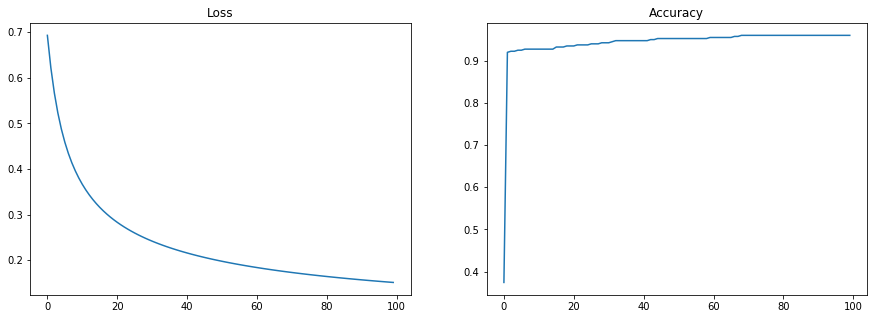

Accuracy on the test set: 0.9883040935672515
Balanced Accuracy on the test set: 0.9841269841269842


In [6]:
# Initialize and fit the model.
model = LogisticRegression(n_features=n_features)
loss, acc = model.fit(X[:int(0.7*n_samples), :], y[:int(0.7*n_samples)], iterations=100, learning_rate=1e-4)

# Visualize training.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])

ax1.plot(loss)
ax1.set_title('Loss')

ax2.plot(acc)
ax2.set_title('Accuracy')

plt.show()

# Evaluate on a held-out set
y_pred = model.predict(X[int(0.7*n_samples):])
acc = np.mean(np.round(y_pred)==y[int(0.7*n_samples):])
print("Accuracy on the test set: {}".format(acc))
print("Balanced Accuracy on the test set: {}".format(balanced_accuracy_score(y[int(0.7*n_samples):], np.round(y_pred))))

The balanced-accuracy to beat is around 0.984, lets try with a single tree:

In [7]:
tree = DecisionTreeClassifier(max_depth=10, min_impurity=0.05)
tree.fit(X[:int(0.7*n_samples), :], y[:int(0.7*n_samples)])

# Evaluate on train and test set.
y_pred = tree.predict(X[:int(0.7*n_samples), :])
acc = np.mean(y_pred==y[:int(0.7*n_samples)])
print("Accuracy on the train set: {}".format(acc))

y_pred = tree.predict(X[int(0.7*n_samples):, :])
acc = np.mean(y_pred==y[int(0.7*n_samples):])
print("Accuracy on the test set: {}".format(acc))
print("Balanced Accuracy on the test set: {}".format(balanced_accuracy_score(y[int(0.7*n_samples):], np.round(y_pred))))

Accuracy on the train set: 0.9949748743718593
Accuracy on the test set: 0.9649122807017544
Balanced Accuracy on the test set: 0.9656084656084656


A single tree is not capable of beating the logistic regression model. Will a combination of these?

## Ensembling

### Bagging
Let's try first with a simple bag of trees

In [9]:
# Create the model
base_tree = DecisionTreeClassifier(max_depth=10, min_impurity=0.1)
bag_trees = BaggingClassifier(base_tree, n_models=30)

# Validate
acc = cross_validate(bag_trees, 5)
print("Cross-Validation accuracy: %.3f" % acc)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [16:34<00:00, 198.66s/it]


Cross-Validation accuracy: 0.940
